# Infection Rates

In this script we use the weekly infections on a county level to compute the infection rates. Assuming people are infectious for 7 days, it is easy to compute the infection number for each week as $r = \frac{\#cases\_week\_i+1}{\#cases\_week\_i}$. This number represents the average amount of people each Covid patient infects in that week

Then, we compare a graph of $r$ with covid measures taken on a state level

In [1]:
# Import the necessary packages
import numpy as np
import matplotlib as plt
import pandas as pd
import plotly.express as px
from urllib.request import urlopen
import json
import ipywidgets as widgets
import datetime as dt

import math
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter

# Take all data into account or just 2020 data (for speed)
USE_ALL_DATA = True

# Read in the data. Note that we already checked for missing values and outliers in Visualization.ipynb. We will not repeat
# the code here.
if USE_ALL_DATA:
    df1 = pd.read_csv("RawData/us-counties-2020.csv", dtype={"fips" : str})
    df2 = pd.read_csv("RawData/us-counties-2021.csv", dtype={"fips" : str})
    df3 = pd.read_csv("RawData/us-counties-2022.csv", dtype={"fips" : str})
    df = pd.concat([df1, df2, df3], ignore_index = True)
else:
    df = pd.read_csv("RawData/us-counties-2020.csv", dtype={"fips" : str})

## Data preprocessing

Getting the weekly percentages of infections on county level was already done in Visualization.ipynb, so I copied the code.

In [2]:
# Construct a column containing fips and select only necessary columns
df[['fips', 'state']] = df.apply(lambda row: (row['geoid'][4:], row['geoid'][4:6]), axis = 1, result_type="expand")
df = df[['date', 'fips', 'cases', 'state']]

In [3]:
## Aggregate data per week (both on county level)

# Running time: ~2-3 mins

# Convert 'date' column to a more workable format
if type(df.loc[0, 'date']) == str:
    df['date'] = pd.to_datetime(df['date'])

# Extract the weeks
# Use Monday of the week of the first recorded date as reference
first_date = min(df['date'])
REFERENCE_DATE = first_date - dt.timedelta(days=first_date.weekday())

def get_week_number(row, REFERENCE_DATE):
    DAYS_IN_WEEK = 7
    t = row['date'] - REFERENCE_DATE
    start_of_week = row['date'] - dt.timedelta(days=row['date'].weekday())
    end_of_week = start_of_week + dt.timedelta(days=6)
    return (t.days // DAYS_IN_WEEK, start_of_week, end_of_week)

df[['week', 'startOfWeek', 'endOfWeek']] = \
    df.apply(lambda row: get_week_number(row, REFERENCE_DATE), axis = 1, result_type="expand")

# Aggregate data by weeks and fips 
agg_week_county = df.groupby(['week', 'fips'], as_index = False).agg({"cases" : "sum", "startOfWeek" : "min", "endOfWeek" : "max"})

# Aggregate data by weeks and state
agg_week_state = df.groupby(['week', 'state'], as_index = False).agg({"cases" : "sum", "startOfWeek" : "min", "endOfWeek" : "max"})


In [4]:
# For each state and for each week, compute the infection number. We could also do the same on a county level,
# but this takes a lot of time so we don't.

def get_infection_number(row, all_data):
    cases = row['cases']
    week = row['week']
    state = row['state']
    
    next_week_cases = all_data.loc[(all_data['week'] == week + 1) & (all_data['state'] == state)]
    
    # For debugging
    """
    if row['state'] == "04":
        print("Analizing week", row['week'])
        print("cases")
        print(cases)
        print("")
        print("next week cases")
        print(int(next_week_cases['cases']))
        print("")
    """
    
    if (next_week_cases.shape[0] >= 1) & (cases > 0):
        return int(next_week_cases['cases']) / cases
    else:
        return 0

agg_week_state['r'] = agg_week_state.apply(lambda row: get_infection_number(row, agg_week_state), axis = 1)

In [5]:
# Save agg_week_state for the app and possibly other purposes
agg_week_state.to_csv("PreprocessedData/agg_week_state.csv")

agg_week_state

week state  cases startOfWeek  endOfWeek    r
0        0    04      1  2020-01-20 2020-01-26  0.0
1        0    06      2  2020-01-20 2020-01-26  2.0
2        0    17      1  2020-01-20 2020-01-26  1.0
3        0    53      1  2020-01-20 2020-01-26  0.0
4        1    04      0  2020-01-27 2020-02-02  0.0
...    ...   ...    ...         ...        ...  ...
6061   116    56      0  2022-04-11 2022-04-17  0.0
6062   116    60    384  2022-04-11 2022-04-17  0.0
6063   116    69     45  2022-04-11 2022-04-17  0.0
6064   116    72    669  2022-04-11 2022-04-17  0.0
6065   116    78      0  2022-04-11 2022-04-17  0.0

[6066 rows x 6 columns]

## Compare evolution of r with Covid measures taken (on state level)

The values of the infection number seem to oscillate a lot. Maybe this is because states did not report infections consistently. Therefore, also a smoothing curve is fitted to the plots. Perhaps it would be smart to work with the smoothed values as opposed to the actual values.

### Pick a state (f.e. California) and plot the infection numbers

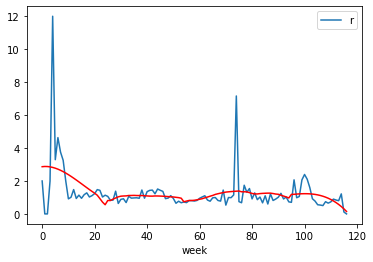

In [6]:
California = agg_week_state.loc[agg_week_state['state'] == "06"]
California.plot(x = 'week', y = 'r')

yhat = savgol_filter(California['r'], 41, 3)
plt.pyplot.plot(California['week'],yhat, color='red')
plt.pyplot.show()

### Pick the first 40 states and plot them

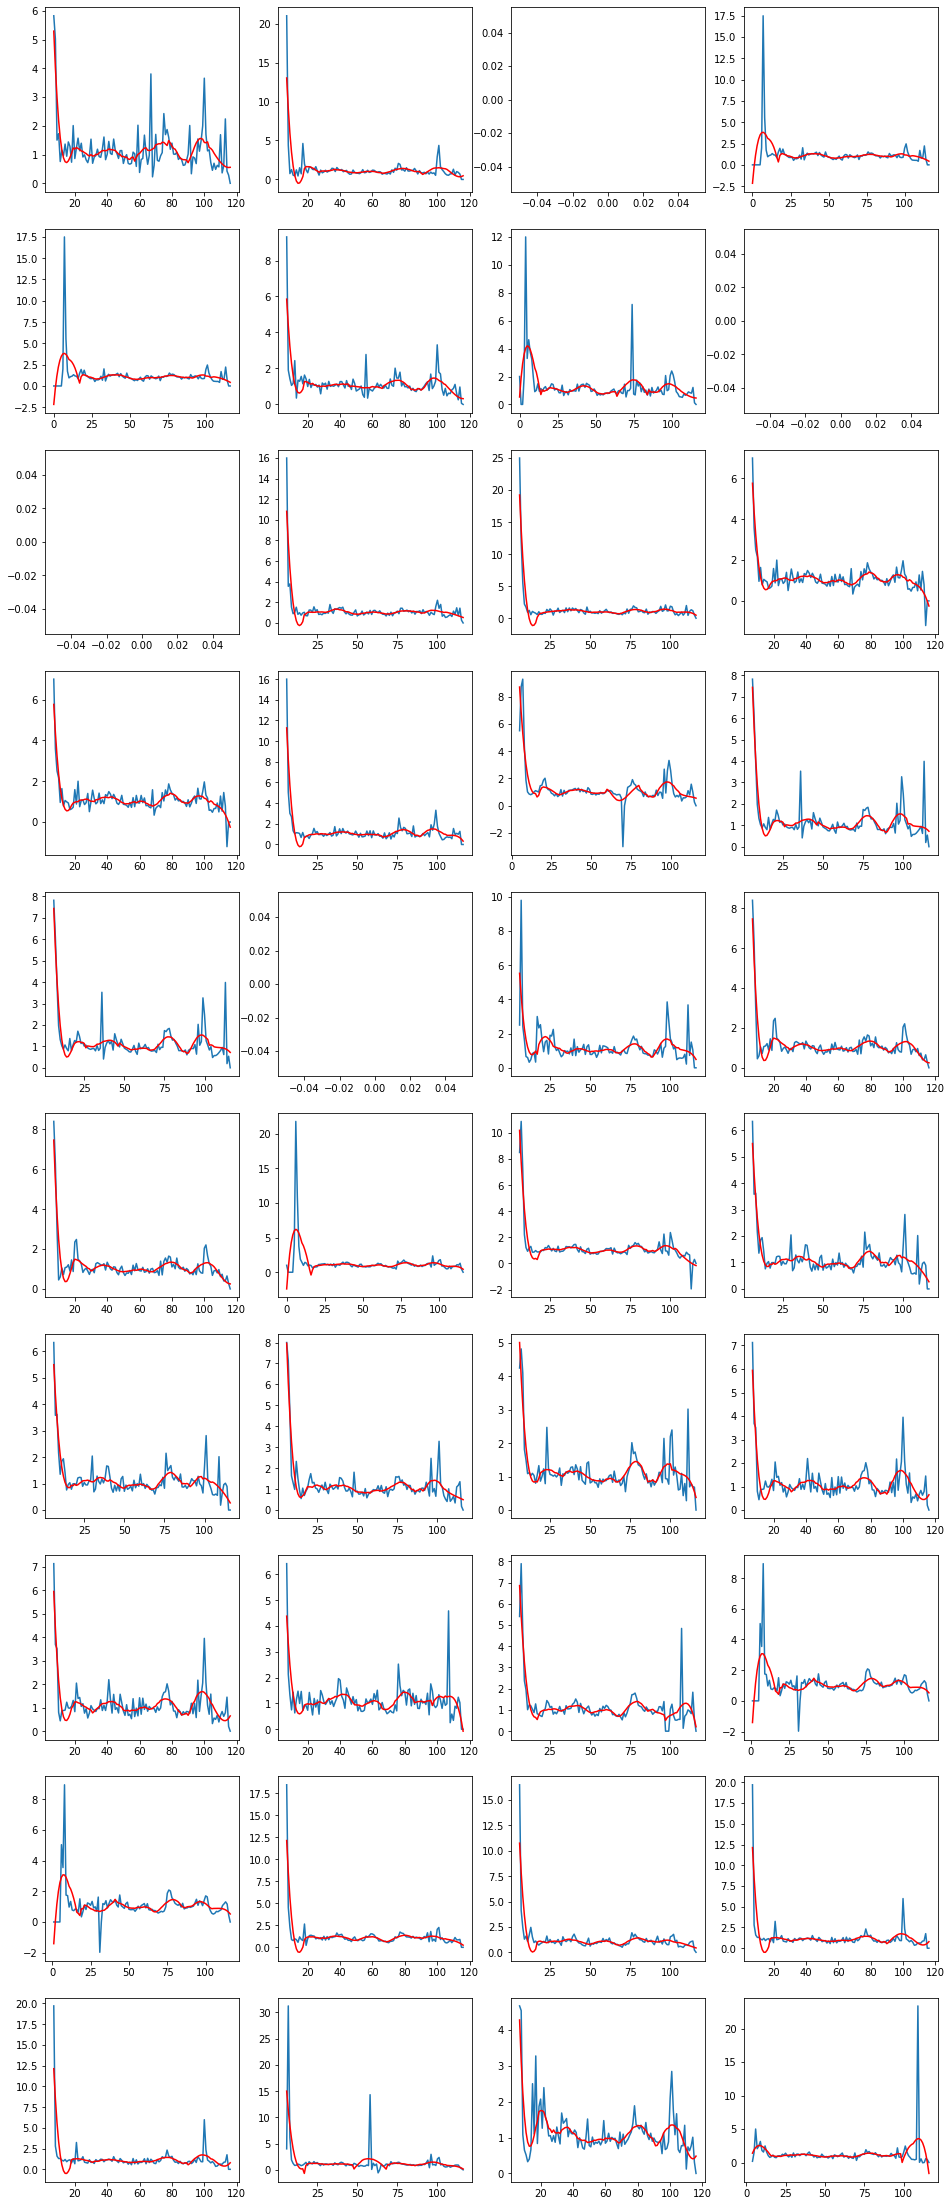

In [7]:
NBR_COLS = 4
NBR_ROWS = 10

fig, axs = plt.pyplot.subplots(NBR_ROWS, NBR_COLS)

fig.set_figheight(4*NBR_ROWS)
fig.set_figwidth(4*NBR_COLS)

for i in range(0, NBR_ROWS):
    for j in range(0, NBR_COLS):
        state_nbr = (i)*3 + j + 1
        if state_nbr < 10:
            state_nbr = "0" + str(state_nbr)
        else:
            state_nbr = str(state_nbr)

        State = agg_week_state.loc[agg_week_state['state'] == state_nbr]
        axs[i,j].plot(State['week'], State['r'])
        # State.plot(x = 'week', y = 'r')

        if State['r'].shape[0] > 21:
            yhat = savgol_filter(State['r'], 21, 3)
            axs[i,j].plot(State['week'],yhat, color='red')

## Overlay these plots with information of Covid measures taken

Displaying the measures taken in terms of closing schools and mask obligation is interesting when comparing them to the smoothing curve.

Legend for the colours:
* Vaccination
    * Red = Vaccination available for all people at risk (elderly, front-line workers, etc.)
    * Green = Vaccination no longer available for all these people (likely because they all got vaccinated)
* Masks
    * Orange = Masks obligatory in all public spaces where social distancing is not possible
    * Blue = Opposite of orange
* Schools
    * Brown = At least some types of schools need to close
    * Yellow = No such restrictions

In [8]:
measures = pd.read_csv("PreprocessedData/covidMeasures.csv")

# Drop first row (doesn't indicate any changes)
measures = measures.loc[1:,]
measures.reset_index(inplace = True, drop = True)

# Get week number of measures taken (REFERENCE_DATE is initialized above)
def get_week_measures(row, REFERENCE_DATE):
    DAYS_IN_WEEK = 7
    date = dt.datetime.strptime(row['Date'], "%Y-%m-%d")
    
    t = date - REFERENCE_DATE
    return (t.days // DAYS_IN_WEEK)

measures['week'] = measures.apply(lambda row: get_week_measures(row, REFERENCE_DATE), axis = 1)

measures.to_csv("PreprocessedData/measures.csv")
measures

fips  Vaccination  Masks  Close_schools        Date  week
0       2            0      0              1  2020-03-16     8
1       2            0      1              1  2020-06-29    23
2       2            1      1              1  2021-03-09    59
3       2            1      1              0  2021-03-15    60
4       2            1      0              0  2021-11-22    96
..    ...          ...    ...            ...         ...   ...
500    56            0      0              0  2020-09-28    36
501    56            0      0              1  2020-10-28    40
502    56            0      0              0  2020-12-30    49
503    56            1      0              0  2021-04-19    65
504    56            0      0              0  2022-04-26   118

[505 rows x 6 columns]

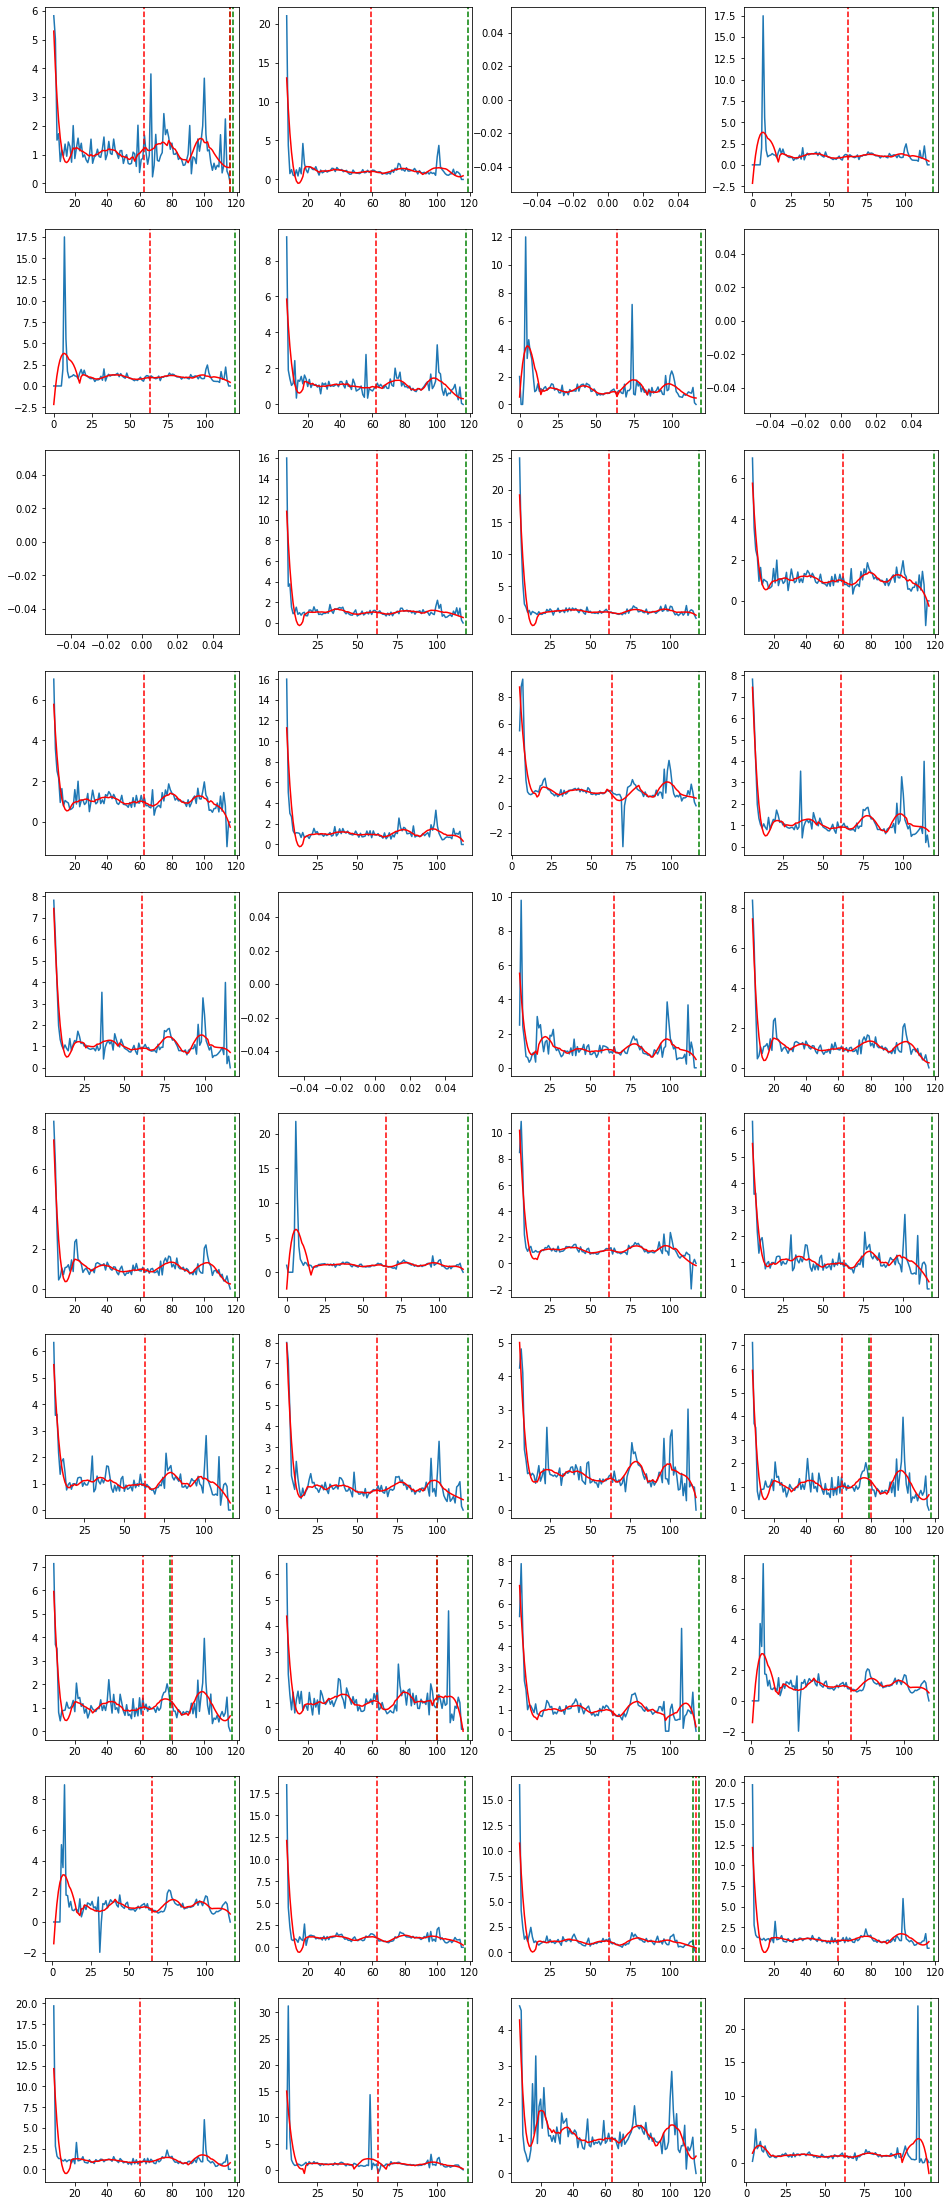

In [9]:
DISPLAY_VACCINATION = True
DISPLAY_MASKS = False
DISPLAY_SCHOOLS = False

NBR_COLS = 4
NBR_ROWS = 10

fig, axs = plt.pyplot.subplots(NBR_ROWS, NBR_COLS)

fig.set_figheight(4*NBR_ROWS)
fig.set_figwidth(4*NBR_COLS)

for i in range(0, NBR_ROWS):
    for j in range(0, NBR_COLS):
        state_nbr_int = (i)*3 + j + 1
        if state_nbr_int < 10:
            state_nbr = "0" + str(state_nbr_int)
        else:
            state_nbr = str(state_nbr_int)

        State = agg_week_state.loc[agg_week_state['state'] == state_nbr]
        axs[i,j].plot(State['week'], State['r'])
        # State.plot(x = 'week', y = 'r')

        if State['r'].shape[0] > 21:
            yhat = savgol_filter(State['r'], 21, 3)
            axs[i,j].plot(State['week'],yhat, color='red')
        
        # Display Vaccination data
        if DISPLAY_VACCINATION:
            state_measures = measures.loc[measures['fips'] == state_nbr_int, ['week', 'Vaccination']]
            state_measures = state_measures.loc[state_measures['Vaccination'].shift() != state_measures['Vaccination']]
            state_measures.reset_index(inplace = True, drop = True)
            state_measures = state_measures.loc[1:,]
            state_measures.reset_index(inplace = True, drop = True)
            
            for change in range(state_measures.shape[0]):
                week = state_measures.loc[change, 'week']
                c = 'r' if state_measures.loc[change, 'Vaccination'] == 1 else 'g'
                axs[i,j].axvline(x = week, color = c, linestyle = '--')
        
        # Display Vaccination data
        if DISPLAY_MASKS:
            state_measures = measures.loc[measures['fips'] == state_nbr_int, ['week', 'Masks']]
            state_measures = state_measures.loc[state_measures['Masks'].shift() != state_measures['Masks']]
            state_measures.reset_index(inplace = True, drop = True)
            state_measures = state_measures.loc[1:,]
            state_measures.reset_index(inplace = True, drop = True)
            
            for change in range(state_measures.shape[0]):
                week = state_measures.loc[change, 'week']
                c = 'orange' if state_measures.loc[change, 'Masks'] == 1 else 'b'
                axs[i,j].axvline(x = week, color = c, linestyle = '--')
        
        # Display Vaccination data
        if DISPLAY_SCHOOLS:
            state_measures = measures.loc[measures['fips'] == state_nbr_int, ['week', 'Close_schools']]
            state_measures = state_measures.loc[state_measures['Close_schools'].shift() != state_measures['Close_schools']]
            state_measures.reset_index(inplace = True, drop = True)
            state_measures = state_measures.loc[1:,]
            state_measures.reset_index(inplace = True, drop = True)
            
            for change in range(state_measures.shape[0]):
                week = state_measures.loc[change, 'week']
                c = 'brown' if state_measures.loc[change, 'Close_schools'] == 1 else 'y'
                axs[i,j].axvline(x = week, color = c, linestyle = '--')

## Use SVM to predict these smoothed curves

This section is based on the code found here:
https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md?fbclid=IwAR3pwIAcAwMk6gY1vNfvXQ9Xi2QXBwnrw_iDMcgBcbRElvs1qfRkFAvf878

### First, try it out on only one state (California)

In [11]:
# Select California data and plot it
state = agg_week_state.loc[agg_week_state['state'] == '06']

fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(x=state['week'], y=state['r'], name="Infection rates"),
    row=1, col=1)

if state['r'].shape[0] > 21:
    state['yhat'] = savgol_filter(state['r'], 21, 3)
    fig.add_trace(go.Scatter(x=state['week'], y=state['yhat'], name="Smoothed data"),
                  row=1, col=1)

fig.show()

C:\Users\wille\AppData\Local\Temp/ipykernel_1536/3600087609.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Data preprocessing

Before we can apply an SVM to do time series predictions, we first need to reformat the data to the required format for applying a SVM.

In [12]:
# We divide the data into a training and test set. Specify the number of weeks you want the trainset to contain below
test_start_week = 90

train = state.copy()[state.week < test_start_week][['yhat']]
test = state.copy()[state.week >= test_start_week][['yhat']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (90, 1)
Test data shape:  (27, 1)


In [13]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [14]:
# Select a time step. This is equal to 1 + lag of predictions.
timesteps=5

In [15]:
# Reformat the training data with the selected timesteps. Each row in train_data_timesteps contains a sequence of observations
# of length 'timesteps'
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(86, 5)

In [16]:
# Do the same for test data
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(23, 5)

In [17]:
# The last observation of each time series will become the response, which we will try to predict based on all the previous
# observations in that timestep
x_train, y_train = train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,timesteps-1]
x_test, y_test = test_data_timesteps[:,:timesteps-1], test_data_timesteps[:,timesteps-1]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(86, 4) (86,)
(23, 4) (23,)


### Apply a support vector machine regression

In [18]:
# Specify the model

# It does not make sense to tune this parameter.
# epsilon = epsilon of the Vapnik eps-insensitive loss function 

# THESE HYPERPARAMETERS SHOULD BE TUNED!
# Gamma = s.d. of radial basis function (i.e. sigma)
# c = regularization parameter

model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

# Fit the model
model.fit(x_train, y_train)

# Make predictions
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

### Assess the performance of the model

In [ ]:
# Compute the MSE
n = len(y_test_pred)
mse = sum([(y_test_pred[i] - y_test[i])**2 for i in range(len(y_test_pred))])
print("The mse for this model is {}".format(round(mse[0], 4)))

In [ ]:
# Plot the predicted versus actual values
train = state.copy()[state.week <= test_start_week][['yhat']]
test = state.copy()[state.week >= test_start_week][['yhat']]

weeks_training = state.loc[state['week'] <= test_start_week, 'week']
weeks_testing  = state.loc[state['week'] >= test_start_week, 'week']

fig = go.Figure()
fig.add_trace(go.Scatter(x=weeks_training, y=train['yhat'], name="Training data", connectgaps=True))
fig.add_trace(go.Scatter(x=weeks_testing, y=test['yhat'], name="Test data", connectgaps=True))
fig.add_trace(go.Scatter(x=weeks_testing.iloc[timesteps:], y=y_test_pred.flatten(), name="Predicted data", connectgaps=True))

fig.show()

## Now implementing a pipeline that allows us to tune hyperparameters

In [ ]:
test_start_week = 90
timesteps=5

# Define the pipeline. Note that this pipeline does not include the information about the lag
pipe = Pipeline([('regressor', SVR(kernel='rbf', gamma=0.5, C = 10, epsilon = 0.05))])

# Reformat data
state = agg_week_state.loc[agg_week_state['state'] == '06']

if state['r'].shape[0] > 21:
    state['yhat'] = savgol_filter(state['r'], 21, 3)

train = state.copy()[state.week < test_start_week][['week', 'yhat']]
test = state.copy()[state.week >= test_start_week][['week', 'yhat']]
train_data = train.values
test_data = test.values
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,1]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,1]

x_train, y_train = train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,timesteps-1]
x_test, y_test = test_data_timesteps[:,:timesteps-1], test_data_timesteps[:,timesteps-1]

In [ ]:
# Which values to check?
gammas_to_check = 5**np.arange(-2.1, 1.9, 1)
Cs_to_check = 10**np.arange(6)

params = {'regressor__gamma': gammas_to_check,
          'regressor__C': Cs_to_check}

# Search over parameter space using a gridsearch
gridsearch = GridSearchCV(pipe, params, verbose=1).fit(x_train, y_train)

In [ ]:
# Fit pipe with optimal hyperparameters
pipe = Pipeline([('regressor', SVR(kernel='rbf', gamma=gridsearch.best_params_['regressor__gamma'], \
                                   C = gridsearch.best_params_['regressor__C'], epsilon = 0.05))])
pipe.fit(x_train, y_train)

In [ ]:
# Make predictions
y_train_pred = pipe.predict(x_train).reshape(-1,1)
y_test_pred = pipe.predict(x_test).reshape(-1,1)

# Predict k weeks into the future. Use predictions of previous iterations as predictors for next iterations.
to_predict = 30

predicted_values = np.empty((0, 1))
predictors = np.empty((0, 4))
predictors = np.vstack([predictors, np.array(x_test[-1,:])])

for i in range(to_predict):
    predicted_values = np.array([pipe.predict(predictors)])
    new_predictors = predictors[i][range(1,4)]
    new_predictors = np.concatenate([new_predictors, [predicted_values[0][i]]], axis = 0)
    predictors = np.vstack([predictors, new_predictors])



In [ ]:
# Plot the predicted versus actual values using tuned values

# Make it so that the lines in the graph connect
new = pd.DataFrame({'week': [test.iloc[0, 0]], 'yhat': [test.iloc[0, 1]]})
train = pd.concat([train, new])

weeks_training = state.loc[state['week'] <= test_start_week, 'week']
weeks_testing  = state.loc[state['week'] >= test_start_week, 'week']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train['week'], y=train['yhat'], name="Training data", connectgaps=True))
fig.add_trace(go.Scatter(x=test['week'], y=test['yhat'], name="Test data", connectgaps=True))
fig.add_trace(go.Scatter(x=np.arange(test_start_week + timesteps, 117 + to_predict), \
                         y=np.concatenate([y_test_pred.flatten(), predicted_values[0][range(1,to_predict)]]), \
                         name="Predicted data", connectgaps=True))

fig.show()

## What would have happened if vaccinations didn't exist?

In this section, we train an svm on the data before vaccinations were made available for all people at risk. Next, we can predict the infection rates for the whole period and compare these predictions with the actual data. The hope is that in this way we can see the effect of vaccinations on the infection rates.

The reality is that there is too little training data to train the SVM, so predictions are nearly always just straight lines, indicating they are not good enough to allow for any meaningful interpretation.

In [ ]:
# Load in state data
agg_week_state = pd.read_csv("PreprocessedData/agg_week_state.csv", index_col = False)

# Select a state
selected_state = 6

state = agg_week_state.loc[agg_week_state['state'] == selected_state]

# Load in measure data
measures = pd.read_csv("PreprocessedData/measures.csv")

# Preprocess the vaccination data
state_measures = measures.loc[measures['fips'] == selected_state, ['week', 'Vaccination']]
state_measures = state_measures.loc[state_measures['Vaccination'].shift() != state_measures['Vaccination']]
state_measures.reset_index(inplace = True, drop = True)
state_measures = state_measures.loc[1:,]
state_measures.reset_index(inplace = True, drop = True)

# Define the pipeline. Note that this pipeline does not include the information about the lag
pipe = Pipeline([('regressor', SVR(kernel='rbf', gamma=0.5, C = 10, epsilon = 0.05))])

# Get the week from which point onwards vaccinations became available
test_start_week = state_measures.loc[state_measures['Vaccination'] == 1].iloc[0, 0]

# Still use lag = 4
timesteps = 15

state['yhat'] = savgol_filter(state['r'], 21, 3)

train = state.copy()[state.week < test_start_week][['week', 'yhat']]
test = state.copy()[state.week >= test_start_week][['week', 'yhat']]
train_data = train.values
test_data = test.values
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,1]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,1]

x_train, y_train = train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,timesteps-1]
x_test, y_test = test_data_timesteps[:,:timesteps-1], test_data_timesteps[:,timesteps-1]

# Which values to check?
gammas_to_check = 5**np.arange(-2.1, 1.9, 1)
Cs_to_check = 10**np.arange(6)

params = {'regressor__gamma': gammas_to_check,
          'regressor__C': Cs_to_check}

# Search over parameter space using a gridsearch
gridsearch = GridSearchCV(pipe, params, verbose=0).fit(x_train, y_train)
print(gridsearch.best_params_)

# Predict the remaining weeks
to_predict = 116 - test_start_week

predicted_values = np.empty((0, 1))
predictors = np.empty((0, timesteps - 1))
predictors = np.vstack([predictors, np.array(x_train[-1,:])])

for i in range(to_predict):
    predicted_values = np.array([gridsearch.predict(predictors)])
    new_predictors = predictors[i][range(1,timesteps-1)]
    new_predictors = np.concatenate([new_predictors, [predicted_values[0][i]]], axis = 0)
    predictors = np.vstack([predictors, new_predictors])

# Plot the predicted versus actual values using tuned values

# Make it so that the lines connect
predicted_values = np.insert(predicted_values, 0, train.iloc[-1, 1])

new = pd.DataFrame({'week': [train.iloc[-1, 0]], 'yhat': [train.iloc[-1, 1]]})
test = pd.concat([new, test])

weeks_training = state.loc[state['week'] <= test_start_week, 'week']
weeks_testing  = state.loc[state['week'] >= test_start_week, 'week']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train['week'], y=train['yhat'], name="Training data", connectgaps=True))
fig.add_trace(go.Scatter(x=test['week'], y=test['yhat'], name="Test data", connectgaps=True))
fig.add_trace(go.Scatter(x=np.arange(test_start_week - 1, 116 ), \
                         y=predicted_values[range(0,to_predict)], \
                         name="Predicted data", connectgaps=True))

fig.show()